In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# 2. Đọc file dữ liệu chứng khoán Eximbank và chia tập train test theo tỉ lệ 8:2
df = pd.read_csv('Eximbank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15667.169, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15679.216, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15665.878, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15667.413, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15677.282, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15664.996, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15666.507, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15665.874, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15664.387, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15665.924, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15665.476, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15662.363, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15665.461, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15663.922, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [6]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[15879.25303687 15877.01117384 15873.56868122 15869.63702982
 15865.50847541 15861.30306612 15857.07010957 15852.82985421
 15848.59061135 15844.35578875 15840.12677984 15835.90415062
 15831.68812719 15827.47879604 15823.27618631 15819.08030362
 15814.8911439  15810.70869915 15806.53295972 15802.36391534
 15798.20155546 15794.04586944 15789.89684662 15785.75447632
 15781.61874789 15777.48965067 15773.36717403 15769.25130736
 15765.14204006 15761.03936155 15756.94326127 15752.85372866
 15748.7707532  15744.69432437 15740.62443168 15736.56106464
 15732.5042128  15728.4538657  15724.41001292 15720.37264404
 15716.34174867 15712.31731643 15708.29933695 15704.28779989
 15700.28269492 15696.28401172 15692.29174    15688.30586948
 15684.3263899  15680.353291   15676.38656256 15672.42619437
 15668.47217621 15664.52449792 15660.58314933 15656.64812029
 15652.71940066 15648.79698033 15644.8808492  15640.97099719
 15637.06741422 15633.17009025 15629.2

In [7]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 3202.2267422481395


In [8]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 15.605122092007761


In [9]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 2928.7416495157786


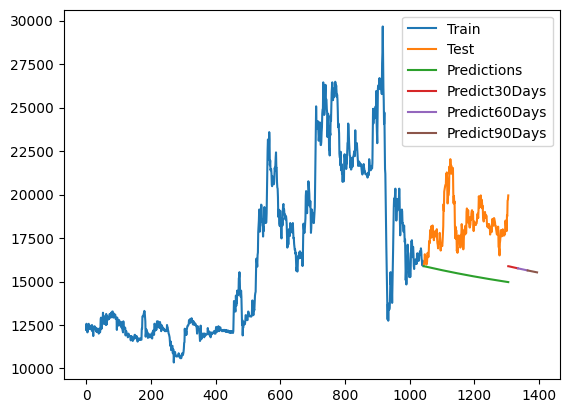

In [10]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

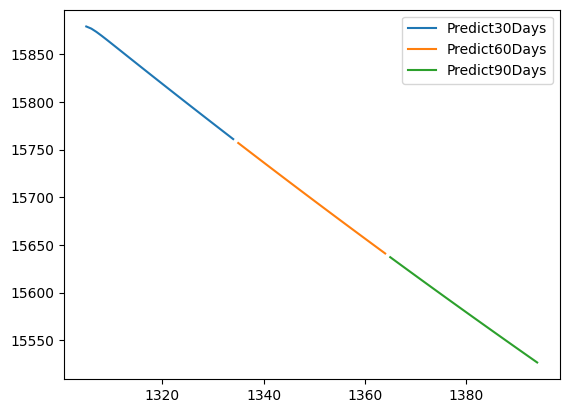

In [11]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()